# fine_tune() vs fit_one_cycle()

In [1]:
from fastai.vision.all import *

In [2]:
path = untar_data(URLs.MNIST)
path.ls()

(#2) [Path('/root/.fastai/data/mnist_png/training'),Path('/root/.fastai/data/mnist_png/testing')]

In [5]:
Path.BASE_PATH = path
path.ls(), (path/'testing').ls()

((#2) [Path('training'),Path('testing')],
 (#10) [Path('testing/8'),Path('testing/3'),Path('testing/9'),Path('testing/2'),Path('testing/4'),Path('testing/1'),Path('testing/0'),Path('testing/5'),Path('testing/7'),Path('testing/6')])

In [12]:
fname = get_image_files(path)
fname[:5], parent_label(fname[0])

((#5) [Path('training/8/23232.png'),Path('training/8/3581.png'),Path('training/8/27348.png'),Path('training/8/35145.png'),Path('training/8/13065.png')],
 '8')

In [15]:
mnist = DataBlock(
    blocks = [ImageBlock(cls=PILImageBW), CategoryBlock],
    get_items=get_image_files,
    splitter=GrandparentSplitter('training', 'testing'),
    get_y=parent_label)
mnist.summary(path)

Setting-up type transforms pipelines
Found 70000 items
2 datasets of sizes 60000,10000
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/mnist_png/training/8/23232.png
    applying PILBase.create gives
      PILImageBW mode=L size=28x28
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/mnist_png/training/8/23232.png
    applying parent_label gives
      8
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(8)

Final sample: (PILImageBW mode=L size=28x28, TensorCategory(8))


Found 70000 items
2 datasets of sizes 60000,10000
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
Setting up after_item: Pipelin

In [23]:
dls = mnist.dataloaders(path, bs=256)

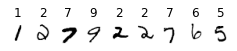

In [24]:
dls.show_batch(ncols=9, figsize=(4,4))

In [32]:
X, y = dls.valid.one_batch()
X.shape, y.shape, X[0,0,:14,14], y[:9]

(torch.Size([256, 1, 28, 28]),
 torch.Size([256]),
 TensorImageBW([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3922, 0.9882, 0.9647,
         0.2392, 0.0000, 0.0157, 0.6118, 0.9882], device='cuda:0'),
 TensorCategory([8, 8, 8, 8, 8, 8, 8, 8, 8], device='cuda:0'))

# Vanilla fine_tune()

In [38]:
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.268339,0.522245,0.912200,00:29


epoch,train_loss,valid_loss,accuracy,time
0,0.062585,0.033629,0.990700,00:29


# fine_tune() with lr_find()

SuggestedLRs(valley=0.0010000000474974513)

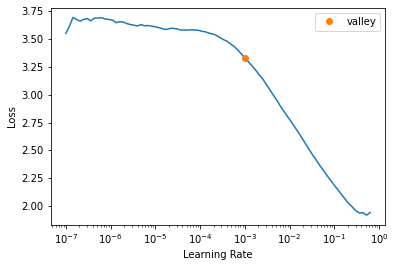

In [45]:
learn = vision_learner(dls, resnet18, metrics=accuracy)
#lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))
learn.lr_find()

In [47]:
learn.fine_tune(1, base_lr=0.03)

epoch,train_loss,valid_loss,accuracy,time
0,0.077246,0.094525,0.982400,00:27


epoch,train_loss,valid_loss,accuracy,time
0,0.055067,0.030450,0.991000,00:28


# fit_one_cycle() after lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.165410,0.146592,0.962900,00:25
1,0.071531,0.056035,0.984200,00:22
2,0.039154,0.029686,0.990500,00:26


SuggestedLRs(valley=3.981071586167673e-06)

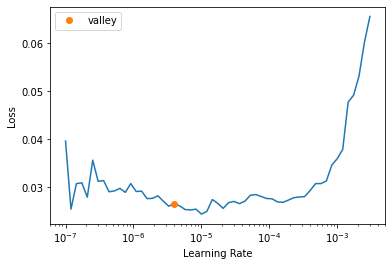

In [48]:
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fit_one_cycle(3, 0.03)
learn.unfreeze()
learn.lr_find()

In [49]:
learn.fit_one_cycle(6, lr_max=5e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.028148,0.027282,0.990700,00:25
1,0.028248,0.026331,0.991300,00:26
2,0.017925,0.026180,0.992400,00:27
3,0.012465,0.024204,0.992600,00:25
4,0.006333,0.023429,0.993100,00:26
5,0.005000,0.023680,0.993600,00:28


# Discriminative LR

epoch,train_loss,valid_loss,accuracy,time
0,0.178551,0.122690,0.964300,00:24
1,0.076595,0.047100,0.986100,00:24
2,0.037789,0.027752,0.992100,00:26


epoch,train_loss,valid_loss,accuracy,time
0,0.026517,0.027263,0.992300,00:24
1,0.027518,0.026565,0.992000,00:23
2,0.024748,0.025845,0.992500,00:26
3,0.023407,0.025002,0.992700,00:23
4,0.015296,0.024018,0.992600,00:28
5,0.015998,0.024011,0.992700,00:30
6,0.012829,0.024593,0.992800,00:29
7,0.012620,0.025312,0.992600,00:31
8,0.012434,0.024796,0.992800,00:33
9,0.009450,0.025069,0.992800,00:32


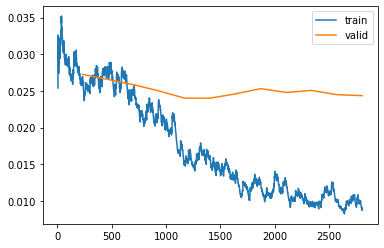

In [50]:
learn = vision_learner(dls, resnet18, metrics=accuracy)
learn.fit_one_cycle(3, 0.03)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))
learn.recorder.plot_loss()

# to_fp16() + fine_tune(free_epochs)

In [53]:
from fastai.callback.fp16 import *
learn = vision_learner(dls, resnet50, metrics=accuracy).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

epoch,train_loss,valid_loss,accuracy,time
0,1.094105,0.660184,0.792900,00:23
1,0.612468,0.398040,0.876300,00:33
2,0.340697,0.232054,0.925600,00:28


epoch,train_loss,valid_loss,accuracy,time
0,0.117487,0.071663,0.977600,00:31
1,0.061673,0.049561,0.984400,00:28
2,0.031958,0.038238,0.988400,00:29
3,0.016311,0.034266,0.990400,00:29
4,0.003950,0.028339,0.992500,00:32
5,0.000928,0.026444,0.993000,00:29
